In [1]:
import model,utils
import local_datasets
from simulator import init_a_bit_less

import torch
from torch.utils.data import DataLoader 

from matplotlib import pyplot as plt

In [2]:
trainset = local_datasets.Character_Dataset(device='cpu', directory='./datasets/Characters',invert=False)
trainloader = DataLoader(trainset,batch_size=int(1),shuffle=True)

In [3]:
encoder = model.E2E_Encoder(in_channels=1, binary_stimulation=True).to('cpu')
pMap,sigma_0, activation_mask, threshold, thresh_slope, args = init_a_bit_less(use_cuda=False)
simulator = model.E2E_RealisticPhospheneSimulator(pMap,sigma_0, activation_mask, threshold, thresh_slope, args, device='cpu').to('cpu')

assuming some standard values for display
1 dva shown as 68.32625810246216 pixels
device: cpu


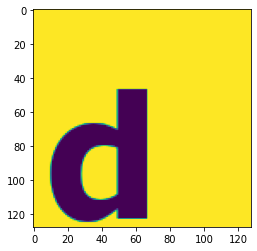

In [4]:
image, label = next(iter(trainloader))

plt.imshow(image[0][0])

In [9]:
stim = encoder(image)
proxy = 40*torch.ones_like(stim,device='cpu')
img = simulator(proxy).cpu().numpy()

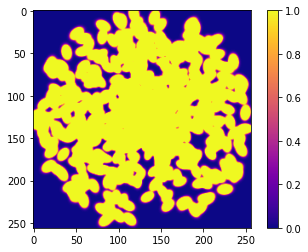

In [10]:
plt.imshow(img[0][0],cmap='plasma')
plt.colorbar()